This notebook takes us from off‐the‐shelf baselines to a full feature‐engineering loop. After initially evaluating models (Decision Tree, XGBoost, SVM, LSTM, etc.) on all 562 raw features, we applied targeted feature selection—pruning down to the top 100 statistical and spectral metrics—to sharpen signal and reduce dimensionality. We then augmented that core 100-feature set with engineered representations (AR coefficients, PCA components, autoencoder/VAE latents), reshaped into short “sequences” where needed, and retrained the same suite of classifiers and sequence models. Finally, each model was rigorously evaluated (10-fold CV + hold-out test metrics) and compared, yielding clear insights into which engineered features and architectures deliver the best HAR performance.

In [ ]:
!unzip /content/archive.zip -d /content/

Archive:  /content/archive.zip
  inflating: /content/test.csv       
  inflating: /content/train.csv      


#Imports and Settings
We import all necessary libraries for data handling, modeling, and evaluation.

In [ ]:
import os
import zipfile
import requests
import numpy as np
import pandas as pd
from scipy.fft import rfft
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Load the processed train/test CSVs with 562 pre-computed features + 'Activity'.

In [ ]:
# ─── 1) Download & unzip UCI HAR raw signals ───────────────────────────────────
UCI_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
ZIP_PATH  = "UCI_HAR.zip"
DATA_DIR  = "UCI_HAR_Dataset"

if not os.path.exists(DATA_DIR):
    print("Downloading raw UCI HAR dataset…")
    r = requests.get(UCI_URL)
    with open(ZIP_PATH, "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall()      # creates folder 'UCI HAR Dataset'
    os.rename("UCI HAR Dataset", DATA_DIR)

# ─── 2) Load your feature CSVs (563 features) ─────────────────────────────────
train_df = pd.read_csv("./train.csv")  # adjust path if needed
test_df  = pd.read_csv("./test.csv")

In [ ]:
train_df = train_df.drop(columns='subject')
train_df.head()
test_df = test_df.drop(columns='subject')
test_df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.190422,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.344418,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,STANDING
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.534685,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,STANDING


In [ ]:
train_df['Activity'].value_counts()

,count
Activity,
LAYING,1407
STANDING,1374
SITTING,1286
WALKING,1226
WALKING_UPSTAIRS,1073
WALKING_DOWNSTAIRS,986


In [ ]:
print(train_df.shape)

(7352, 562)


<b> Filter Based Feature Selection</b>

### Filter-based feature selection techniques are methods that use statistical measures to score each feature independently, and then select a subset of features based on these scores. These methods are called "filter" methods because they essentially filter out the features that do not meet some criterion.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Separate features and target
X_train = train_df.drop('Activity', axis=1)
y_train = train_df['Activity']
X_test = test_df.drop('Activity', axis=1)
y_test = test_df['Activity']

# Encode target labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(7352, 561)
(2947, 561)


In [ ]:
# Initialize and train logistic regression model
log_reg = LogisticRegression(max_iter=1000)  # Increase max_iter if it doesn't converge
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Calculate and print accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

Test accuracy: 0.9616559212758737


 <h2 style='background:blue; border:0; color:white'><center>The first method we look at is Duplicate Features which are different features (or columns) in a dataset that provide have the same or very similar values. These redundant features can lead to inefficiencies in model training and can also cause overfitting, where the model learns noise in the data rather than the underlying patterns.</center></h2>

In [ ]:
def get_duplicate_columns(df):

    duplicate_columns = {}
    seen_columns = {}

    for column in df.columns:
        current_column = df[column]

        # Convert column data to bytes
        try:
            current_column_hash = current_column.values.tobytes()
        except AttributeError:
            current_column_hash = current_column.to_string().encode()
        if current_column_hash in seen_columns:
            if seen_columns[current_column_hash] in duplicate_columns:
                duplicate_columns[seen_columns[current_column_hash]].append(column)
            else:
                duplicate_columns[seen_columns[current_column_hash]] = [column]
        else:
            seen_columns[current_column_hash] = column

    return duplicate_columns

In [ ]:
duplicate_columns = get_duplicate_columns(X_train)
duplicate_columns

{'tBodyAccMag-mean()': ['tBodyAccMag-sma()',
  'tGravityAccMag-mean()',
  'tGravityAccMag-sma()'],
 'tBodyAccMag-std()': ['tGravityAccMag-std()'],
 'tBodyAccMag-mad()': ['tGravityAccMag-mad()'],
 'tBodyAccMag-max()': ['tGravityAccMag-max()'],
 'tBodyAccMag-min()': ['tGravityAccMag-min()'],
 'tBodyAccMag-energy()': ['tGravityAccMag-energy()'],
 'tBodyAccMag-iqr()': ['tGravityAccMag-iqr()'],
 'tBodyAccMag-entropy()': ['tGravityAccMag-entropy()'],
 'tBodyAccMag-arCoeff()1': ['tGravityAccMag-arCoeff()1'],
 'tBodyAccMag-arCoeff()2': ['tGravityAccMag-arCoeff()2'],
 'tBodyAccMag-arCoeff()3': ['tGravityAccMag-arCoeff()3'],
 'tBodyAccMag-arCoeff()4': ['tGravityAccMag-arCoeff()4'],
 'tBodyAccJerkMag-mean()': ['tBodyAccJerkMag-sma()'],
 'tBodyGyroMag-mean()': ['tBodyGyroMag-sma()'],
 'tBodyGyroJerkMag-mean()': ['tBodyGyroJerkMag-sma()'],
 'fBodyAccMag-mean()': ['fBodyAccMag-sma()'],
 'fBodyBodyAccJerkMag-mean()': ['fBodyBodyAccJerkMag-sma()'],
 'fBodyBodyGyroMag-mean()': ['fBodyBodyGyroMag-sma()'

#### We can look at the duplicated values here for the below 4 columns

In [ ]:
X_train[['tBodyAccMag-mean()','tBodyAccMag-sma()','tGravityAccMag-mean()','tGravityAccMag-sma()']]

,tBodyAccMag-mean(),tBodyAccMag-sma(),tGravityAccMag-mean(),tGravityAccMag-sma()
0,-0.959434,-0.959434,-0.959434,-0.959434
1,-0.979289,-0.979289,-0.979289,-0.979289
2,-0.983703,-0.983703,-0.983703,-0.983703
3,-0.986542,-0.986542,-0.986542,-0.986542
4,-0.992827,-0.992827,-0.992827,-0.992827
...,...,...,...,...
7347,-0.031719,-0.031719,-0.031719,-0.031719
7348,-0.065256,-0.065256,-0.065256,-0.065256
7349,-0.003936,-0.003936,-0.003936,-0.003936
7350,-0.002445,-0.002445,-0.002445,-0.002445


In [ ]:
for one_list in duplicate_columns.values():
    X_train.drop(columns=one_list,inplace=True)
    X_test.drop(columns=one_list,inplace=True)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(7352, 540)
(2947, 540)


# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b> Variance Threshold</b></div>

The variance threshold method is used to remove features with low variance, which means they do not vary much and thus do not provide useful information for explaining the variation in the output. For example, if we have features A and B and an output column C, and B has low variance, it means B does not contribute significantly to explaining the variation in C.

This method is applied to two types of features:

1. **Constant Features**: These are features where all values are the same.
2. **Quasi-Constant Features**: These features have the same value for the vast majority of rows (e.g., 995 out of 1000 rows have the same value), with only a few different values.

The process involves:

1. Setting a variance threshold.
2. Calculating the variance for all features.
3. Dropping features that have a variance below the threshold.

#### We normalize or standardize the dataset first because, without doing so, we might need to use different threshold values for differnt features. By normalizing, it is generally accepted that a threshold value between 0.1 and 0.01 is effective for identifying low-variance features.

In [ ]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.05)

In [ ]:
sel.fit(X_train)

VarianceThreshold(threshold=0.05)

In [ ]:
sum(sel.get_support())

np.int64(349)

In [ ]:
sel.get_support()

array([False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False,  True,
        True,  True, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True, False,  True, False,  True, False,  True,  True,
        True,  True,  True, False, False, False,  True,  True,  True,
        True,  True,

In [ ]:
columns = X_train.columns[sel.get_support()]
columns

Index(['tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X', 'tBodyAcc-max()-Y', 'tBodyAcc-max()-Z',
       'tBodyAcc-min()-X',
       ...
       'fBodyBodyGyroJerkMag-meanFreq()', 'fBodyBodyGyroJerkMag-skewness()',
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)'],
      dtype='object', length=349)

In [ ]:
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(7352, 349)
(2947, 349)


In [ ]:
X_train.head()

,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,-0.576159,-0.829711,0.843609,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,-0.569174,-0.824705,0.849095,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892



# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b> Points to consider while applying variance threshold</b></div>
1. **Ignores Target Variable**: The Variance Threshold method is univariate, meaning it evaluates each feature independently without considering the relationship between each feature and the target variable. As a result, it may retain irrelevant features with high variance that do not correlate with the target, or it may discard useful features with low variance that have a strong relationship with the target.

2. **Ignores Feature Interactions**: This method does not account for interactions between features. A feature with low variance might be highly informative when combined with another feature, but the Variance Threshold method would not capture this.

3. **Sensitive to Data Scaling**: The Variance Threshold is sensitive to the scale of the data. Features with larger values will naturally have higher variances. Therefore, it is crucial to standardize features before applying the Variance Threshold.

4. **Arbitrary Threshold Value**: Defining what constitutes "low" variance is subjective and up to the user. The optimal threshold value can vary between datasets, making it challenging to determine the best value for a specific dataset.

<h2 style='background:blue; border:0; color:white'><center>Pearson Correlation in Removing Multicollinearity</center></h2>

To remove multicollinearity, we use Pearson correlation to identify and remove features that are highly correlated with each other. This helps ensure that the features in the dataset are not providing redundant information, which can improve the performance and interpretability of machine learning models.

In short, we calculate the Pearson correlation coefficient for all pairs of features and remove one of the features from each pair that has a correlation coefficient above a certain threshold (e.g., 0.9 or -0.9), indicating a strong linear relationship.

<Axes: >

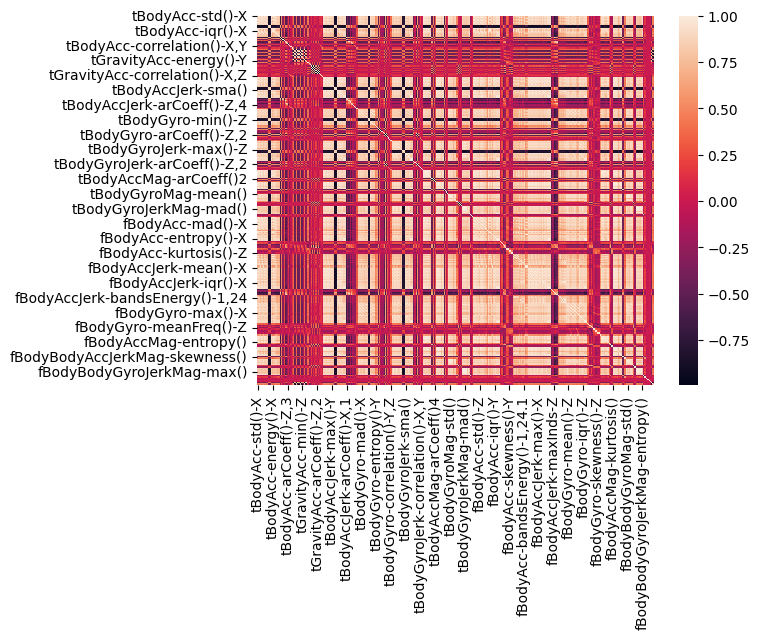

In [ ]:
import seaborn as sns
sns.heatmap(X_train.corr())

##### We can see that is heatmap is quite compact so just by looking at it we cannot draw any results

In [ ]:
X_train.corr()

,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
tBodyAcc-std()-X,1.000000,0.927461,0.851668,0.998632,0.920888,0.846392,0.980844,0.895217,0.844993,-0.966500,...,-0.065987,0.148034,0.115565,-0.035011,-0.021633,0.018985,-0.024810,-0.371653,0.471065,0.394825
tBodyAcc-std()-Y,0.927461,1.000000,0.895510,0.922803,0.997347,0.894509,0.917366,0.953573,0.884490,-0.937918,...,-0.105621,0.206227,0.176946,-0.020379,-0.012505,-0.008507,-0.014592,-0.380531,0.523600,0.433169
tBodyAcc-std()-Z,0.851668,0.895510,1.000000,0.844469,0.891441,0.997418,0.853884,0.866820,0.937802,-0.860691,...,-0.097978,0.157792,0.126701,-0.006769,-0.020036,-0.018429,-0.006471,-0.345011,0.476006,0.482828
tBodyAcc-mad()-X,0.998632,0.922803,0.844469,1.000000,0.916106,0.839267,0.973216,0.889934,0.838920,-0.962235,...,-0.059972,0.149257,0.117804,-0.042713,-0.021537,0.019389,-0.024951,-0.368191,0.466424,0.390922
tBodyAcc-mad()-Y,0.920888,0.997347,0.891441,0.916106,1.000000,0.891178,0.910411,0.949550,0.879898,-0.933135,...,-0.102908,0.200890,0.172809,-0.023722,-0.012310,-0.012546,-0.012341,-0.377025,0.525081,0.431459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"angle(tBodyGyroMean,gravityMean)",0.018985,-0.008507,-0.018429,0.019389,-0.012546,-0.023525,0.025066,-0.007806,-0.028210,-0.002334,...,-0.026615,0.034514,0.024553,-0.006269,0.009141,1.000000,-0.116001,-0.005853,-0.012313,-0.019903
"angle(tBodyGyroJerkMean,gravityMean)",-0.024810,-0.014592,-0.006471,-0.024951,-0.012341,-0.007231,-0.028871,-0.000297,-0.001207,0.017876,...,0.000102,-0.017937,-0.014865,-0.020823,0.035263,-0.116001,1.000000,0.023995,-0.005869,-0.005656
"angle(X,gravityMean)",-0.371653,-0.380531,-0.345011,-0.368191,-0.377025,-0.347389,-0.384192,-0.372172,-0.346824,0.362847,...,0.087332,-0.086006,-0.079751,0.011880,0.023246,-0.005853,0.023995,1.000000,-0.783848,-0.643655
"angle(Y,gravityMean)",0.471065,0.523600,0.476006,0.466424,0.525081,0.477607,0.480229,0.490324,0.463763,-0.470812,...,-0.100125,0.086993,0.078079,0.001540,-0.012990,-0.012313,-0.005869,-0.783848,1.000000,0.594885


In [ ]:
corr_matrix = X_train.corr()

In [ ]:
# Get the column names of the DataFrame
columns = corr_matrix.columns

# Create an empty list to keep track of columns to drop
columns_to_drop = []

# Loop over the columns
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        # Access the cell of the DataFrame
        if corr_matrix.loc[columns[i], columns[j]] > 0.95:
            columns_to_drop.append(columns[j])

print(len(columns_to_drop))

1513


In [ ]:
columns_to_drop = set(columns_to_drop)
len(columns_to_drop)

197

In [ ]:
X_train.drop(columns = columns_to_drop, axis = 1, inplace=True)
X_test.drop(columns = columns_to_drop, axis = 1, inplace=True)
print(X_train.shape)
print(X_test.shape)

(7352, 152)
(2947, 152)


In [ ]:
X_train

,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,...,fBodyBodyGyroMag-skewness(),fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,-0.995279,-0.983111,-0.913526,-0.744413,0.852947,0.685845,0.814263,-0.407747,-0.679338,-0.602122,...,0.586156,-0.074323,-0.298676,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,-0.998245,-0.975300,-0.960322,-0.818409,0.849308,0.685845,0.822637,-0.714892,-0.500930,-0.570979,...,-0.336310,0.158075,-0.595051,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,-0.995380,-0.967187,-0.978944,-0.818409,0.843609,0.682401,0.839344,-0.592235,-0.485821,-0.570979,...,-0.535352,0.414503,-0.390748,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,-0.996091,-0.983403,-0.990675,-0.829711,0.843609,0.682401,0.837869,-0.627446,-0.850930,-0.911872,...,-0.230091,0.404573,-0.117290,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,-0.998139,-0.980817,-0.990482,-0.824705,0.849095,0.683250,0.837869,-0.786553,-0.559477,-0.761434,...,-0.510282,0.087753,-0.351471,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,-0.195387,0.039905,0.077078,-0.076700,0.273480,0.186626,0.266917,0.195643,0.140158,-0.082077,...,-0.170845,-0.070157,-0.588433,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819
7348,-0.235309,0.004816,0.059280,-0.031966,0.282174,0.202880,0.266917,0.178138,0.293566,-0.051532,...,0.019626,0.165259,-0.390738,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053
7349,-0.218218,-0.103822,0.274533,0.055411,0.263175,0.202880,0.264670,0.173131,0.276040,0.152003,...,0.490169,0.195034,0.025145,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811
7350,-0.219139,-0.111412,0.268893,0.055411,0.234850,0.237784,0.264670,0.160333,0.246561,0.021678,...,0.308105,0.013865,0.063907,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339





# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b> Disadvantages while using Pearson Correlation</b></div>

1. **Linearity Assumption**: Correlation measures the linear relationship between two variables and does not effectively capture non-linear relationships. If the relationship is non-linear, the correlation coefficient can be misleading.

2. **Doesn't Capture Complex Relationships**: Correlation only assesses the relationship between two variables at a time, failing to account for complex interactions involving more than two variables.

3. **Threshold Determination**: Similar to the variance threshold method, defining what level of correlation is considered "high" can be subjective and may vary depending on the specific problem or dataset.

4. **Sensitive to Outliers**: Correlation is sensitive to outliers, and a few extreme values can significantly skew the correlation coefficient.

# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:#0f7a7a; overflow:hidden"><b> ANOVA Test </b></div>


### The ANOVA (Analysis of Variance) test is a statistical method used to determine if there are significant differences between the means of three or more groups.

In [ ]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

sel = SelectKBest(f_classif, k=100).fit(X_train, y_train)

# display selected feature names
X_train.columns[sel.get_support()]

Index(['tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-max()-Z', 'tBodyAcc-min()-X', 'tBodyAcc-min()-Y',
       'tBodyAcc-min()-Z', 'tBodyAcc-entropy()-X', 'tBodyAcc-entropy()-Y',
       'tBodyAcc-entropy()-Z', 'tBodyAcc-arCoeff()-X,1',
       'tBodyAcc-arCoeff()-X,2', 'tBodyAcc-arCoeff()-X,3',
       'tBodyAcc-arCoeff()-Y,1', 'tBodyAcc-arCoeff()-Z,1',
       'tBodyAcc-correlation()-X,Y', 'tBodyAcc-correlation()-Y,Z',
       'tGravityAcc-mean()-X', 'tGravityAcc-mean()-Y', 'tGravityAcc-mean()-Z',
       'tGravityAcc-sma()', 'tGravityAcc-energy()-Y', 'tGravityAcc-energy()-Z',
       'tGravityAcc-entropy()-X', 'tGravityAcc-entropy()-Y',
       'tGravityAcc-arCoeff()-Y,1', 'tGravityAcc-arCoeff()-Y,2',
       'tGravityAcc-arCoeff()-Z,1', 'tGravityAcc-arCoeff()-Z,2',
       'tGravityAcc-correlation()-Y,Z', 'tBodyAccJerk-std()-Z',
       'tBodyAccJerk-min()-X', 'tBodyAccJerk-min()-Y', 'tBodyAccJerk-min()-Z',
       'tBodyAccJerk-entropy()-X', 'tBodyAccJerk-arCoeff

In [ ]:
columns = X_train.columns[sel.get_support()]

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(7352, 100)
(2947, 100)


In [ ]:
X_train.head()

,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,...,fBodyGyro-meanFreq()-Z,"fBodyGyro-bandsEnergy()-1,8.1",fBodyAccMag-maxInds,fBodyBodyAccJerkMag-min(),fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyGyroMag-meanFreq(),"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,-0.995279,-0.983111,-0.913526,-0.744413,0.852947,0.685845,0.814263,-0.407747,-0.679338,-0.602122,...,0.547151,-0.999454,-0.793103,-0.988175,0.346989,-0.516080,-0.128989,-0.841247,0.179941,-0.058627
1,-0.998245,-0.975300,-0.960322,-0.818409,0.849308,0.685845,0.822637,-0.714892,-0.500930,-0.570979,...,-0.068178,-0.999856,-1.000000,-0.989549,0.532061,-0.624871,-0.271958,-0.844788,0.180289,-0.054317
2,-0.995380,-0.967187,-0.978944,-0.818409,0.843609,0.682401,0.839344,-0.592235,-0.485821,-0.570979,...,-0.110720,-0.999954,-0.862069,-0.999890,0.660795,-0.724697,-0.212728,-0.848933,0.180637,-0.049118
3,-0.996091,-0.983403,-0.990675,-0.829711,0.843609,0.682401,0.837869,-0.627446,-0.850930,-0.911872,...,-0.049728,-0.999931,-1.000000,-0.995562,0.678921,-0.701131,-0.035684,-0.848649,0.181935,-0.047663
4,-0.998139,-0.980817,-0.990482,-0.824705,0.849095,0.683250,0.837869,-0.786553,-0.559477,-0.761434,...,-0.162230,-0.999926,-1.000000,-0.982177,0.559058,-0.528901,-0.273582,-0.847865,0.185151,-0.043892


### Now let us look after all these hardwork if we are getting better results than before.

In [ ]:
# Initialize and train logistic regression model
log_reg = LogisticRegression(max_iter=1000)  # Increase max_iter if it doesn't converge
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Calculate and print accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

Test accuracy: 0.9307770614183916


<h2 style='background:blue; border:0; color:white'><center>Disadvantages of using ANOVA test </center></h2>

1. **Assumption of Normality**: ANOVA assumes that the data for each group follow a normal distribution. This assumption may not hold true for all datasets, particularly those with skewed distributions.

2. **Assumption of Homogeneity of Variance**: ANOVA assumes that the variances of different groups are equal, known as the assumption of homogeneity of variance (or homoscedasticity). Violating this assumption can lead to incorrect results.

3. **Independence of Observations**: ANOVA assumes that the observations are independent of each other. This might not be the case in datasets where observations are related, such as time series data or nested data.

4. **Effect of Outliers**: ANOVA is sensitive to outliers. A single outlier can significantly affect the F-statistic, potentially leading to erroneous conclusions.

5. **Doesn't Account for Interactions**: Like other univariate feature selection methods, ANOVA does not consider interactions between features.

# Save Feature Engineered data

In [ ]:
train = X_train
test  = X_test
train["Activity"] = y_train
test["Activity"] = y_test


In [ ]:
# prompt: save df in csv

train.to_csv('train_processed.csv', index=False)
test.to_csv('test_processed.csv', index=False)


# SVM

In [ ]:
# 1. Imports and setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

# If running in a notebook:
# %matplotlib inline


Combined shape: (7352, 101)
Sample columns: Index(['fBodyBodyGyroMag-meanFreq()', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object')


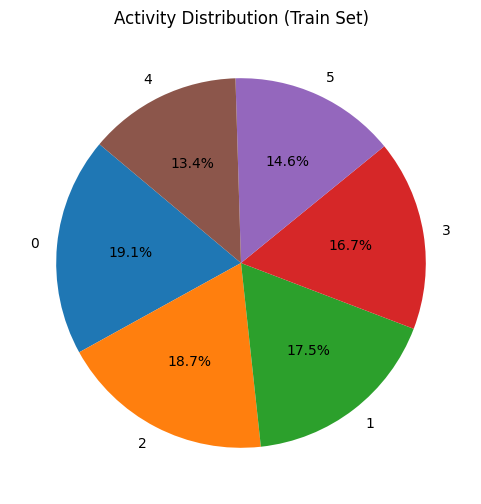

In [ ]:
import pandas as pd

# 1. Convert X_train (numpy) → DataFrame
#    If you don’t have explicit feature names, pandas will default to integers 0…99
#X_train_df = pd.DataFrame(X_train)
# Adjust these paths if your CSVs live elsewhere
train = X_train
test  = X_test

# 2. Add y_train as a new column called "Activity"
train["Activity"] = y_train
test["Activity"] = y_test

# 3. (Optional) Quick sanity check:
print("Combined shape:", X_train.shape)    # should be (n_samples, 101)
print("Sample columns:", X_train.columns[-5:])  # shows last few, including "Activity"

# 4. Now plot:
activity_counts = X_train["Activity"].value_counts()
plt.figure(figsize=(6,6))
plt.pie(activity_counts, labels=activity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Activity Distribution (Train Set)")
plt.show()

In [ ]:
# 2. Load and shuffle data
# Adjust these paths if your CSVs live elsewhere
train = X_train
test  = X_test

# Quick sanity check
print("Train shape:", train.shape)
print("Test  shape:", test.shape)
print("Any missing in train?", train.isnull().any().any())
print("Any missing in test? ", test.isnull().any().any())


Train shape: (7352, 101)
Test  shape: (2947, 101)
Any missing in train? False
Any missing in test?  False


In [ ]:
# # 3. Explore class distribution
# activity_counts = train["Activity"].value_counts()
# plt.figure(figsize=(6,6))
# plt.pie(activity_counts, labels=activity_counts.index, autopct='%1.1f%%', startangle=140)
# plt.title("Activity Distribution (Train Set)")
# plt.show()

In [ ]:
# Encode string labels as integers
le = LabelEncoder().fit(y_train)
y_train_enc = le.transform(y_train)
y_test_enc  = le.transform(y_test)

print("Classes:", le.classes_)

Classes: [0 1 2 3 4 5]


In [ ]:
# 5. Scale numeric features
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
# 6. Define SVM parameter grid and perform 5-fold CV
param_grid = [
    {"kernel": ["rbf"],    "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]}
]

svm_cv = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1, verbose=1)
svm_cv.fit(X_train_scaled, y_train_enc)

# Record best estimator
best_svm = svm_cv.best_estimator_

print("Best params:", svm_cv.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1407
           1       1.00      1.00      1.00      1286
           2       1.00      1.00      1.00      1374
           3       1.00      1.00      1.00      1226
           4       1.00      1.00      1.00       986
           5       1.00      1.00      1.00      1073

    accuracy                           1.00      7352
   macro avg       1.00      1.00      1.00      7352
weighted avg       1.00      1.00      1.00      7352

--- Train Metrics ---
Accuracy: 1.0000


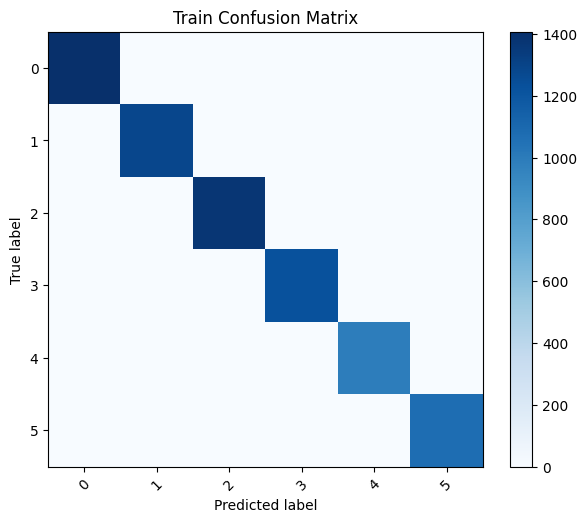

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       1.00      1.00      1.00       491
           2       1.00      1.00      1.00       532
           3       0.99      1.00      0.99       496
           4       1.00      0.98      0.99       420
           5       0.99      1.00      0.99       471

    accuracy                           1.00      2947
   macro avg       1.00      1.00      1.00      2947
weighted avg       1.00      1.00      1.00      2947

--- Test Metrics ---
Accuracy: 0.9963


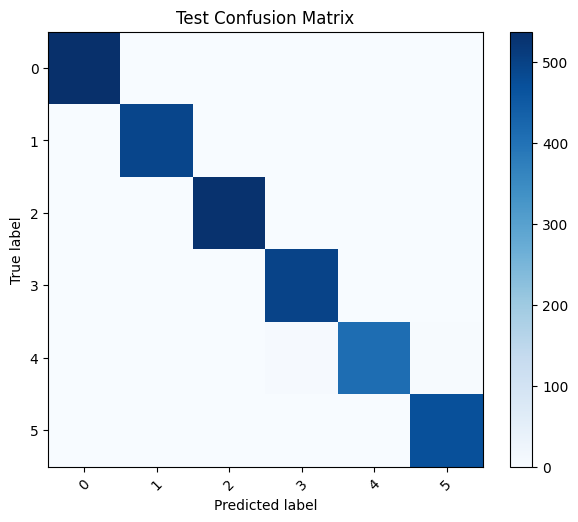

In [ ]:
# 7. Evaluate on train and test
for split, X, y in [("Train", X_train_scaled, y_train_enc),
                   ("Test",  X_test_scaled,  y_test_enc)]:
    y_pred = best_svm.predict(X)
    print(classification_report(y, y_pred))
    print(f"--- {split} Metrics ---")
    print(f"Accuracy: {best_svm.score(X, y):.4f}")
    #print(classification_report(y, y_pred, target_names=le.classes_))
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6,5))
    plt.title(f"{split} Confusion Matrix")
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xticks(range(len(le.classes_)), le.classes_, rotation=45)
    plt.yticks(range(len(le.classes_)), le.classes_)
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

In [ ]:
train

,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,...,"fBodyGyro-bandsEnergy()-1,8.1",fBodyAccMag-maxInds,fBodyBodyAccJerkMag-min(),fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyGyroMag-meanFreq(),"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,-0.995279,-0.983111,-0.913526,-0.744413,0.852947,0.685845,0.814263,-0.407747,-0.679338,-0.602122,...,-0.999454,-0.793103,-0.988175,0.346989,-0.516080,-0.128989,-0.841247,0.179941,-0.058627,2
1,-0.998245,-0.975300,-0.960322,-0.818409,0.849308,0.685845,0.822637,-0.714892,-0.500930,-0.570979,...,-0.999856,-1.000000,-0.989549,0.532061,-0.624871,-0.271958,-0.844788,0.180289,-0.054317,2
2,-0.995380,-0.967187,-0.978944,-0.818409,0.843609,0.682401,0.839344,-0.592235,-0.485821,-0.570979,...,-0.999954,-0.862069,-0.999890,0.660795,-0.724697,-0.212728,-0.848933,0.180637,-0.049118,2
3,-0.996091,-0.983403,-0.990675,-0.829711,0.843609,0.682401,0.837869,-0.627446,-0.850930,-0.911872,...,-0.999931,-1.000000,-0.995562,0.678921,-0.701131,-0.035684,-0.848649,0.181935,-0.047663,2
4,-0.998139,-0.980817,-0.990482,-0.824705,0.849095,0.683250,0.837869,-0.786553,-0.559477,-0.761434,...,-0.999926,-1.000000,-0.982177,0.559058,-0.528901,-0.273582,-0.847865,0.185151,-0.043892,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,-0.195387,0.039905,0.077078,-0.076700,0.273480,0.186626,0.266917,0.195643,0.140158,-0.082077,...,-0.053258,-0.793103,-0.937302,-0.066650,-0.076714,-0.376234,-0.791883,0.238604,0.049819,5
7348,-0.235309,0.004816,0.059280,-0.031966,0.282174,0.202880,0.266917,0.178138,0.293566,-0.051532,...,-0.029411,-0.793103,-0.805086,-0.193946,-0.151879,-0.296176,-0.771840,0.252676,0.050053,5
7349,-0.218218,-0.103822,0.274533,0.055411,0.263175,0.202880,0.264670,0.173131,0.276040,0.152003,...,0.161404,-0.793103,-0.786822,0.007099,0.331457,-0.320249,-0.779133,0.249145,0.040811,5
7350,-0.219139,-0.111412,0.268893,0.055411,0.234850,0.237784,0.264670,0.160333,0.246561,0.021678,...,0.193585,-0.793103,-0.694837,-0.109902,0.038175,-0.412332,-0.785181,0.246432,0.025339,5


# PCA  + Mutliple models
XGBoost leverages gradient-boosted decision trees to excel on tabular HAR data by automatically learning non-linear interactions among hand-crafted time- and frequency-domain features. Its ensemble of weak learners iteratively focuses on misclassified windows, achieving fast convergence and strong generalization—even with limited training samples—and often outperforms deep nets when feature engineering already captures most signal patterns.

Decision Trees offer an intuitive, rule-based approach to HAR by recursively partitioning feature space according to the most discriminative time- and frequency-domain statistics. At each node, the tree selects the feature and threshold that best separates activities (e.g. “if mean acceleration > 0.8, go left; else go right”), building a hierarchy of simple decisions. This results in a fully interpretable model that can capture non-linear interactions without heavy preprocessing, making it a quick, baseline classifier for sensor-based activity recognition.

Support Vector Machines (SVMs) excel at HAR by finding optimal hyperplanes in feature space to separate activities based on statistical summaries. When paired with PCA, we first compress all 100 time- and frequency-domain features into a lower-dimensional subspace that preserves 99 % of variance, then a linear SVM distinguishes activities along those principal axes. Using only time-domain features focuses the SVM on temporal statistics (mean, variance, autocorrelation), while using only frequency-domain features hones in on spectral signatures (FFT coefficients, band energies). In practice, the PCA+SVM pipeline delivers robust, compact models, and the specialized time-only or freq-only SVMs reveal which domain carries the strongest separability for each activity.


Original features: 100 PCA reduced: 65
DecisionTree_Full: Train Acc=1.000, Test Acc=1.000, Train Prec=1.000, Test Prec=1.000, Train Rec=1.000, Test Rec=1.000
XGB_Full: Train Acc=1.000, Test Acc=1.000, Train Prec=1.000, Test Prec=1.000, Train Rec=1.000, Test Rec=1.000
LinearSVC_PCA: Train Acc=0.972, Test Acc=0.938, Train Prec=0.974, Test Prec=0.942, Train Rec=0.974, Test Rec=0.937
LinearSVC_Freq: Train Acc=0.921, Test Acc=0.834, Train Prec=0.918, Test Prec=0.834, Train Rec=0.919, Test Rec=0.827
LinearSVC_Time: Train Acc=0.976, Test Acc=0.935, Train Prec=0.978, Test Prec=0.939, Train Rec=0.978, Test Rec=0.934
DecisionTree_PCA: Train Acc=1.000, Test Acc=0.783, Train Prec=1.000, Test Prec=0.780, Train Rec=1.000, Test Rec=0.777
XGB_PCA: Train Acc=1.000, Test Acc=0.914, Train Prec=1.000, Test Prec=0.915, Train Rec=1.000, Test Rec=0.911


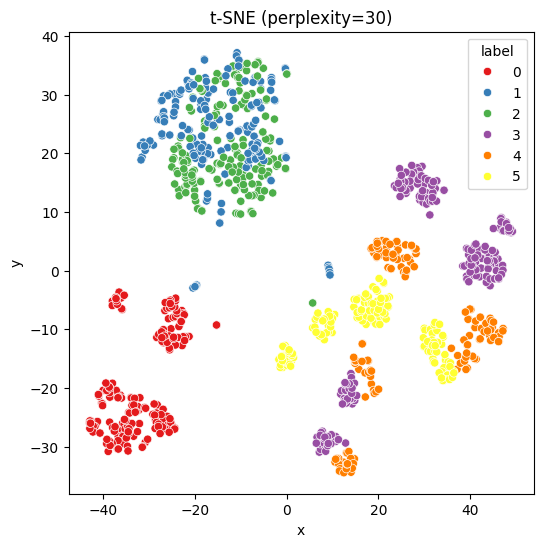

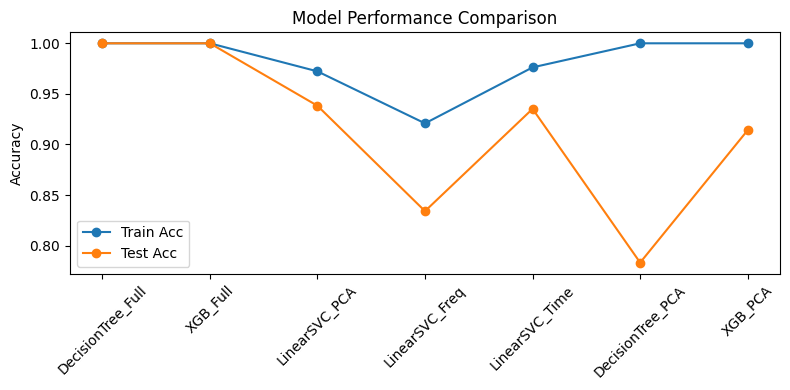

In [ ]:
# Human Activity Recognition Analysis Script

# 1. Imports and settings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn import tree, svm
from xgboost import XGBClassifier
# 2. Load data (adjust paths as needed)
# train_data = pd.read_csv("../input/human-activity-recognition-with-smartphones/train.csv")
# test_data  = pd.read_csv("../input/human-activity-recognition-with-smartphones/test.csv")
# 1. Start with original train and test
train_data = train
test_data = test

# 1. Assume you already have:
# train and test loaded.

# 2. Frequency-domain and Time-domain splits
f_train = train.filter(regex=r'^(f|s|a|A)')
f_test  = test.filter(regex=r'^(f|s|a|A)')
t_train = train.filter(regex=r'^(t|s|a|A)')
t_test  = test.filter(regex=r'^(t|s|a|A)')

# 3. Separate X and y
Xf_train = f_train.drop(columns=['Activity'])
yf_train = f_train['Activity']

Xf_test  = f_test.drop(columns=['Activity'])
yf_test  = f_test['Activity']

Xt_train = t_train.drop(columns=['Activity'])
yt_train = t_train['Activity']

Xt_test  = t_test.drop(columns=['Activity'])
yt_test  = t_test['Activity']

# 4. Full features (no filtering)
X_train_full = train.drop(columns=['Activity'])
y_train_full = train['Activity']

X_test_full  = test.drop(columns=['Activity'])
y_test_full  = test['Activity']

# 5. PCA on full features (fit on train, transform both train and test)
pca = PCA(n_components=0.99, random_state=42)
#X_pca = pca.fit_transform(X_full)
Xp_train = pca.fit_transform(X_train_full)
Xp_test  = pca.transform(X_test_full)

# 6. Final assignments (Xp, yp)
yp_train = y_train_full
yp_test  = y_test_full


# # 3. PCA on full features (retain 99% variance) — fit on train only, transform both train & test
# pca = PCA(n_components=0.99, random_state=42)
# Xp_train = pca.fit_transform(X_full_train)
# Xp_test  = pca.transform(X_full_test)

print("Original features:", X_train_full.shape[1], "PCA reduced:", Xp_train.shape[1])

# Now you have:
# - X_full_train, X_full_test, y_full_train, y_full_test
# - X_freq_train, X_freq_test, y_freq_train, y_freq_test
# - X_time_train, X_time_test, y_time_train, y_time_test
# - Xp_train, Xp_test, yp_train = y_full_train, yp_test = y_full_test


# 7. Label encoding
le = preprocessing.LabelEncoder().fit(y_train)
y_train_enc = le.transform(y_train)
y_test_enc  = le.transform(y_test)

# 8. Evaluation function
results = {}

def evaluate(model, name, X_tr, X_te, y_tr, y_te):
    model.fit(X_tr, y_tr)
    y_pred_tr = model.predict(X_tr)
    y_pred_te = model.predict(X_te)
    tr_acc = model.score(X_tr, y_tr)
    te_acc = model.score(X_te, y_te)
    tr_prec = metrics.precision_score(y_tr, y_pred_tr, average='macro')
    te_prec = metrics.precision_score(y_te, y_pred_te, average='macro')
    tr_rec = metrics.recall_score(y_tr, y_pred_tr, average='macro')
    te_rec = metrics.recall_score(y_te, y_pred_te, average='macro')
    results[name] = {'train': (tr_acc, tr_prec, tr_rec),
                     'test':  (te_acc, te_prec, te_rec)}
    print(f"{name}: Train Acc={tr_acc:.3f}, Test Acc={te_acc:.3f},",
          f"Train Prec={tr_prec:.3f}, Test Prec={te_prec:.3f},",
          f"Train Rec={tr_rec:.3f}, Test Rec={te_rec:.3f}")

# 9. Train and evaluate models
evaluate(tree.DecisionTreeClassifier(random_state=42), 'DecisionTree_Full', X_train, X_test, y_train_enc, y_test_enc)
evaluate(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), 'XGB_Full', X_train, X_test, y_train_enc, y_test_enc)
evaluate(svm.LinearSVC(random_state=42, max_iter=2000), 'LinearSVC_PCA', Xp_train, Xp_test, le.transform(yp_train), le.transform(yp_test))
evaluate(svm.LinearSVC(random_state=42, max_iter=2000), 'LinearSVC_Freq', Xf_train, Xf_test, le.transform(yf_train), le.transform(yf_test))
evaluate(svm.LinearSVC(random_state=42, max_iter=2000), 'LinearSVC_Time', Xt_train, Xt_test, le.transform(yt_train), le.transform(yt_test))
# ─── NEW: Decision Tree on PCA-reduced features ─────────────────────────────
evaluate(tree.DecisionTreeClassifier(random_state=42),
         'DecisionTree_PCA',
         Xp_train, Xp_test,
         le.transform(yp_train), le.transform(yp_test))

# ─── NEW: XGBoost on PCA-reduced features ────────────────────────────────────
evaluate(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
         'XGB_PCA',
         Xp_train, Xp_test,
         le.transform(yp_train), le.transform(yp_test))

# 10. t-SNE visualization
def plot_tsne(X_data, labels, perplexity=30):
    embed = TSNE(n_components=2, perplexity=perplexity, random_state=42).fit_transform(X_data)
    df = pd.DataFrame({'x': embed[:,0], 'y': embed[:,1], 'label': labels})
    plt.figure(figsize=(6,6))
    sns.scatterplot(x='x', y='y', hue='label', data=df, legend='full', palette='Set1')
    plt.title(f"t-SNE (perplexity={perplexity})")
    plt.show()

plot_tsne(Xp_test[:1000], y_test_full.iloc[:1000])

# 11. Compare model accuracies
names = list(results.keys())
train_accs = [results[n]['train'][0] for n in names]
test_accs  = [results[n]['test'][0]  for n in names]

plt.figure(figsize=(8,4))
plt.plot(names, train_accs, marker='o', label='Train Acc')
plt.plot(names, test_accs,  marker='o', label='Test Acc')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)
from scipy.special import softmax

def evaluate_model(model, name, X_tr, X_te, y_tr, y_te, cv_splits=10):
    """10-fold CV + full test metrics (with softmax on decision scores if needed)."""
    # 1) Cross-validate on training set
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
    cv_res = cross_validate(model, X_tr, y_tr, cv=cv,
                            scoring=scoring, n_jobs=-1)

    # 2) Fit full model & predict on test
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    # 3) Compute ROC-AUC
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_te)
        auc = roc_auc_score(y_te, y_probs, multi_class='ovr')
    elif hasattr(model, "decision_function"):
        # Convert decision scores to probabilities
        scores = model.decision_function(X_te)   # shape (n_samples, n_classes)
        # apply softmax per sample
        y_probs = softmax(scores, axis=1)
        auc = roc_auc_score(y_te, y_probs, multi_class='ovr')
    else:
        auc = np.nan

    # 4) Test-set metrics
    acc  = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, average='macro', zero_division=0)
    rec  = recall_score(y_te, y_pred, average='macro', zero_division=0)
    f1   = f1_score(y_te, y_pred, average='macro', zero_division=0)
    cm   = confusion_matrix(y_te, y_pred)

    # 5) Print summary
    print(f"\n{name} – "
          f"CV Acc={cv_res['test_accuracy'].mean():.3f}±{cv_res['test_accuracy'].std():.3f}, "
          f"Test Acc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}, F1={f1:.3f}, AUC={auc:.3f}")
    print("Confusion Matrix:\n", cm)

    # 6) Return if you want to store
    return {
        'cv_acc':    (cv_res['test_accuracy'].mean(), cv_res['test_accuracy'].std()),
        'test_acc':  acc,
        'test_prec': prec,
        'test_rec':  rec,
        'test_f1':   f1,
        'test_auc':  auc,
        'conf_mat':  cm
    }


In [ ]:
# # 9. Train and evaluate models
# evaluate_model(tree.DecisionTreeClassifier(random_state=42), 'DecisionTree_Full', X_train, X_test, y_train_enc, y_test_enc)
# evaluate_model(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), 'XGB_Full', X_train, X_test, y_train_enc, y_test_enc)
# evaluate_model(svm.LinearSVC(random_state=42, max_iter=2000), 'LinearSVC_PCA', Xp_train, Xp_test, le.transform(yp_train), le.transform(yp_test))
# evaluate_model(svm.LinearSVC(random_state=42, max_iter=2000), 'LinearSVC_Freq', Xf_train, Xf_test, le.transform(yf_train), le.transform(yf_test))
# evaluate_model(svm.LinearSVC(random_state=42, max_iter=2000), 'LinearSVC_Time', Xt_train, Xt_test, le.transform(yt_train), le.transform(yt_test))

In [ ]:
import pandas as pd

# 1) List your models (replace with your actual variables)
models = [
    ("DecisionTree_Full", tree.DecisionTreeClassifier(random_state=42), X_train, X_test, y_train_enc, y_test_enc),
    ("XGB_Full",          XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
                          X_train, X_test, y_train_enc, y_test_enc),
    ("LinearSVC_PCA",     svm.LinearSVC(max_iter=2000, random_state=42),
                          Xp_train, Xp_test, le.transform(yp_train), le.transform(yp_test)),
    ("LinearSVC_Freq",    svm.LinearSVC(max_iter=2000, random_state=42),
                          Xf_train, Xf_test, le.transform(yf_train), le.transform(yf_test)),
    ("LinearSVC_Time",    svm.LinearSVC(max_iter=2000, random_state=42),
                          Xt_train, Xt_test, le.transform(yt_train), le.transform(yt_test)),
    # add your deep‐model wrappers similarly:
    # ("LSTM",           lstm_clf, X_train_raw, X_test_raw, y_train_int, y_test_int),
    # ("PINN",           pinn_clf, X_train_raw, X_test_raw, y_train_int, y_test_int),
    # ("Transformer",    transformer_clf, X_train_raw, X_test_raw, y_train_int, y_test_int),
]

# 2) Evaluate and collect results
records = []
for name, clf, X_tr, X_te, y_tr, y_te in models:
    print(f"--> {name}")
    res = evaluate_model(clf, name, X_tr, X_te, y_tr, y_te, cv_splits=10)
    # Flatten the cv_acc tuple into two fields
    cv_mean, cv_std = res.pop('cv_acc')
    record = {
        'Model':        name,
        'CV Acc Mean':  cv_mean,
        'CV Acc Std':   cv_std,
        'Test Acc':     res['test_acc'],
        'Test Prec':    res['test_prec'],
        'Test Rec':     res['test_rec'],
        'Test F1':      res['test_f1'],
        'Test AUC':     res['test_auc']
        # you can also store 'conf_mat': res['conf_mat'] if desired
    }
    records.append(record)

# 3) Build the DataFrame
df_results = pd.DataFrame.from_records(records)
df_results = df_results.set_index('Model')
print("\n=== Comparison Table ===")
print(df_results)


--> DecisionTree_Full

DecisionTree_Full – CV Acc=1.000±0.000, Test Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000, AUC=1.000
Confusion Matrix:
 [[537   0   0   0   0   0]
 [  0 491   0   0   0   0]
 [  0   0 532   0   0   0]
 [  0   0   0 496   0   0]
 [  0   0   0   0 420   0]
 [  0   0   0   0   0 471]]
--> XGB_Full

XGB_Full – CV Acc=1.000±0.000, Test Acc=1.000, Prec=1.000, Rec=1.000, F1=1.000, AUC=1.000
Confusion Matrix:
 [[537   0   0   0   0   0]
 [  0 491   0   0   0   0]
 [  0   0 532   0   0   0]
 [  0   0   0 496   0   0]
 [  0   0   0   0 420   0]
 [  0   0   0   0   0 471]]
--> LinearSVC_PCA

LinearSVC_PCA – CV Acc=0.968±0.004, Test Acc=0.938, Prec=0.942, Rec=0.937, F1=0.938, AUC=0.994
Confusion Matrix:
 [[537   0   0   0   0   0]
 [  0 409  80   0   0   2]
 [  0  34 495   2   0   1]
 [  0   0   0 493   3   0]
 [  0   0   0  13 397  10]
 [  0   0   0  34   3 434]]
--> LinearSVC_Freq

LinearSVC_Freq – CV Acc=0.917±0.006, Test Acc=0.834, Prec=0.834, Rec=0.827, F1=0.829, AUC=0.97

## LSTM
LSTM networks excel at HAR because each activity window (e.g. a 2.5-second burst of accelerometer and gyroscope readings) naturally forms a short time series with meaningful temporal patterns—like the rhythm of steps or the sequence of a sit-to-stand. By feeding that sequence into an LSTM, its gated memory cells learn when to retain versus discard past information, so the final hidden state becomes a rich summary of the entire motion. That summary, passed through a simple classifier, lets the model distinguish activities (walking vs. sitting) based not just on instantaneous sensor values but on how those values evolve over time.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

# 1. Prepare your data (assumes X_train, y_train are NumPy arrays)
#    X_train shape: (n_samples, timesteps, n_features)
#    y_train shape: (n_samples,)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_tensor = torch.from_numpy(X_train.values).float()
y_tensor = torch.from_numpy(y_train).long()

# Create dataset and split off a validation set
full_ds = TensorDataset(X_tensor, y_tensor)
n_val = int(len(full_ds) * 0.3)
n_train = len(full_ds) - n_val
train_ds, val_ds = random_split(full_ds, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)

# 2. Define the model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout=0.3):
        super().__init__()
        # hidden_dims: list of ints, e.g. [256,128,64]
        self.lstm1 = nn.LSTM(input_dim,  hidden_dims[0], batch_first=True, bidirectional=False)
        self.drop1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_dims[0], hidden_dims[1], batch_first=True)
        self.drop2 = nn.Dropout(dropout)
        self.lstm3 = nn.LSTM(hidden_dims[1], hidden_dims[2], batch_first=True)
        self.fc1   = nn.Linear(hidden_dims[2], 32)
        self.fc2   = nn.Linear(32, output_dim)

    def forward(self, x):
        # x: (batch, seq_len, features)
        out, _ = self.lstm1(x)
        out     = self.drop1(out)
        out, _ = self.lstm2(out)
        out     = self.drop2(out)
        out, _ = self.lstm3(out)
        # take last timestep
       # out     = out[:, -1, :]
        out     = torch.relu(self.fc1(out))
        out     = self.fc2(out)
        return out
# Reshape X_train to (num_samples, sequence_length, num_features)
X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])

# ... (In your model definition) ...

n_features = X_train_reshaped.shape[2]  # Now access the correct dimension
# ... (rest of the model definition) ...

# When creating the TensorDataset:
X_tensor = torch.from_numpy(X_train_reshaped).float()
# Instantiate
#n_features = X_train.shape[2]
n_classes  = len(torch.unique(y_tensor))
model = LSTMClassifier(
    input_dim=n_features,
    hidden_dims=[256,128,64],
    output_dim=n_classes,
    dropout=0.3
).to(device)

# 3. Loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-3)

# 4. Early stopping helper
class EarlyStopping:
    def __init__(self, patience=10, delta=0.0):
        self.patience = patience
        self.delta    = delta
        self.best_loss = float('inf')
        self.counter   = 0
        self.best_state = None

    def step(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.best_state = {k: v.cpu() for k,v in model.state_dict().items()}
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

    def load_best(self, model):
        model.load_state_dict(self.best_state)

early_stopper = EarlyStopping(patience=10)

# 5. Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # — Training —
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss   = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # — Validation —
    model.eval()
    val_loss = 0.0
    correct  = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            val_loss += criterion(logits, y_batch).item() * X_batch.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y_batch).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc   = correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1:03d}: Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | Val Acc={val_acc:.4f}")

    # Early stopping check
    if early_stopper.step(val_loss, model):
        print(f"Stopping early at epoch {epoch+1}")
        break

# Load best model weights
early_stopper.load_best(model)

# 6. (Optional) Move into your evaluation function
# You can now pass `model` into your existing `evaluate(...)` utility,
# wrapping X_test and y_test in a DataLoader just like above.

# 6. Plot Loss/Accuracy Curves

Epoch 001: Train Loss=1.2033 | Val Loss=0.7477 | Val Acc=0.6222
Epoch 002: Train Loss=0.5423 | Val Loss=0.2501 | Val Acc=0.9156
Epoch 003: Train Loss=0.2862 | Val Loss=0.1313 | Val Acc=0.9651
Epoch 004: Train Loss=0.1496 | Val Loss=0.0783 | Val Acc=0.9741
Epoch 005: Train Loss=0.1054 | Val Loss=0.0393 | Val Acc=0.9905
Epoch 006: Train Loss=0.0986 | Val Loss=0.0628 | Val Acc=0.9787
Epoch 007: Train Loss=0.0930 | Val Loss=0.0244 | Val Acc=0.9918
Epoch 008: Train Loss=0.0519 | Val Loss=0.0149 | Val Acc=0.9959
Epoch 009: Train Loss=0.0428 | Val Loss=0.0457 | Val Acc=0.9850
Epoch 010: Train Loss=0.0289 | Val Loss=0.0135 | Val Acc=0.9968
Epoch 011: Train Loss=0.0441 | Val Loss=0.0138 | Val Acc=0.9968
Epoch 012: Train Loss=0.0290 | Val Loss=0.0032 | Val Acc=0.9991
Epoch 013: Train Loss=0.0333 | Val Loss=0.0047 | Val Acc=0.9986
Epoch 014: Train Loss=0.0398 | Val Loss=0.0077 | Val Acc=0.9977
Epoch 015: Train Loss=0.0418 | Val Loss=0.0039 | Val Acc=0.9991
Epoch 016: Train Loss=0.0416 | Val Loss=

## PINNS
Physics-Informed Neural Networks (PINNs) for HAR extend a standard sequence model (e.g., an LSTM) by enforcing a “physics” constraint alongside the usual classification objective. After the LSTM encodes each window of sensor readings into hidden states, a second head tries to reconstruct a pseudo-signal over time whose second derivative matches the measured accelerations. By penalizing the mean-squared error between that learned acceleration curve’s curvature (d²x/dt²) and the actual sensor values, the network is encouraged to respect underlying motion dynamics—yielding embeddings that not only separate classes but also obey physical consistency, which can improve robustness to noise or unusual gait patterns.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder

# Assuming `train` and `test` are your already loaded DataFrames (with 'Activity' column)

# Encode labels
le = LabelEncoder()
y_train_int = le.fit_transform(train['Activity'])
y_test_int  = le.transform(test['Activity'])

# Drop 'Activity' from features
X_train_np = train.drop(columns=['Activity']).values
X_test_np  = test.drop(columns=['Activity']).values

# Convert to torch tensors
X_tr = torch.tensor(X_train_np, dtype=torch.float32)
y_tr = torch.tensor(y_train_int, dtype=torch.long)
X_te = torch.tensor(X_test_np, dtype=torch.float32)
y_te = torch.tensor(y_test_int, dtype=torch.long)

# Reshape: (n_samples, sequence_length, n_channels)
# Since your features are already flattened, assume sequence_length=1
# X_tr = X_tr.unsqueeze(1)  # → (n_samples, 1, n_features)
# X_te = X_te.unsqueeze(1)  # → (n_samples, 1, n_features)
# Instead of seq_len=1, reshape to seq_len=100, n_channels=1
X_tr = X_tr.view(-1, 100, 1)   # (n_samples, 100, 1)
X_te = X_te.view(-1, 100, 1)


# Build datasets and loaders
train_ds = TensorDataset(X_tr, y_tr)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_ds  = TensorDataset(X_te, y_te)
test_loader = DataLoader(test_ds, batch_size=64)
# 3) Define PINN_HAR as before
class PINN_HAR(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, num_classes=6):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, bidirectional=True)
        self.fc_cls  = nn.Linear(2*hidden_size, num_classes)
        self.fc_phys = nn.Linear(2*hidden_size, input_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        cls_logits = self.fc_cls(out[:, -1, :])
        phys_pred  = self.fc_phys(out)
        return cls_logits, phys_pred
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Adjusted input size
n_features = X_train_np.shape[1]  # number of columns in your processed data
n_classes = len(le.classes_)      # number of activities

# model = PINN_HAR(
#     input_size=n_features,
#     hidden_size=64,
#     num_layers=2,
#     num_classes=n_classes
# ).to(device)
model = PINN_HAR(input_size=1, hidden_size=64, num_layers=2, num_classes=n_classes).to(device)

# # Instantiate model, optimizer, losses
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = PINN_HAR(input_size=6).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
ce_loss = nn.CrossEntropyLoss()
mse_loss = nn.MSELoss()
lambda_phys = 0.1
#lambda_phys = 0.0
# ─── 4) Training loop ─────────────────────────────────────────────────────────
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    model.train()
    total_cls, total_phys = 0.0, 0.0

    for X_batch, y_batch in train_loader:
        Xb = X_batch.to(device)
        yb = y_batch.to(device)

        optimizer.zero_grad()
        logits, phys = model(Xb)

        # Classification loss
        loss_cls = ce_loss(logits, yb)

        # Physics loss: second derivative approx
        d2_phys = phys[:, 2:] - 2 * phys[:, 1:-1] + phys[:, :-2]  # (B,126,6)
        acc_mid = Xb[:, 1:-1, :]                                 # (B,126,6)
        loss_phys = mse_loss(d2_phys, acc_mid)

        # Total loss
        loss = loss_cls + lambda_phys * loss_phys
        loss.backward()
        optimizer.step()

        total_cls  += loss_cls.item()
        total_phys += loss_phys.item()

    avg_cls = total_cls / len(train_loader)
    avg_phys = total_phys / len(train_loader)
    print(f"Epoch {epoch:2d} | CE Loss: {avg_cls:.4f} | Phys Loss: {avg_phys:.4f}")

# ─── Evaluation ───────────────────────────────────────────────────────────────
model.eval()
correct = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        Xb = X_batch.to(device)
        logits, _ = model(Xb)
        preds = logits.argmax(dim=1).cpu()
        correct += (preds == y_batch).sum().item()

accuracy = correct / len(test_ds)
print(f"\nTest Accuracy (PINN): {accuracy:.4f}")



Epoch  1 | CE Loss: 1.4954 | Phys Loss: 0.1987
Epoch  2 | CE Loss: 0.8069 | Phys Loss: 0.0926
Epoch  3 | CE Loss: 0.6637 | Phys Loss: 0.0775
Epoch  4 | CE Loss: 0.5791 | Phys Loss: 0.0731
Epoch  5 | CE Loss: 0.5077 | Phys Loss: 0.0709
Epoch  6 | CE Loss: 0.4901 | Phys Loss: 0.0671
Epoch  7 | CE Loss: 0.4408 | Phys Loss: 0.0617
Epoch  8 | CE Loss: 0.4505 | Phys Loss: 0.0601
Epoch  9 | CE Loss: 0.4039 | Phys Loss: 0.0544
Epoch 10 | CE Loss: 0.3712 | Phys Loss: 0.0519
Epoch 11 | CE Loss: 0.3668 | Phys Loss: 0.0502
Epoch 12 | CE Loss: 0.3330 | Phys Loss: 0.0475
Epoch 13 | CE Loss: 0.3349 | Phys Loss: 0.0461
Epoch 14 | CE Loss: 0.3029 | Phys Loss: 0.0440
Epoch 15 | CE Loss: 0.3063 | Phys Loss: 0.0428
Epoch 16 | CE Loss: 0.2785 | Phys Loss: 0.0406
Epoch 17 | CE Loss: 0.2616 | Phys Loss: 0.0399
Epoch 18 | CE Loss: 0.2724 | Phys Loss: 0.0390
Epoch 19 | CE Loss: 0.2434 | Phys Loss: 0.0370
Epoch 20 | CE Loss: 0.2444 | Phys Loss: 0.0359
Epoch 21 | CE Loss: 0.2544 | Phys Loss: 0.0361
Epoch 22 | CE

# Transformers
Transformer encoders excel in HAR by treating a sequence of sensor-derived features as a series of tokens with positional context, allowing self-attention to learn which time steps matter most. After linearly projecting each timestep’s feature vector into a shared embedding space and adding sinusoidal positional encodings, the Transformer layers compute pairwise attention scores to capture long-range dependencies—e.g., how a subtle shoulder movement at t=10 influences a foot strike at t=80. The final embedding for the last timestep (or a pooled representation) then feeds into a classification head, enabling the model to distinguish activities based on both local patterns and global temporal relationships, without the sequential bottleneck of recurrent nets.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder

# ─── 0) Data Preparation ─────────────────────────────────────────────────────
# Assuming `train` and `test` are loaded DataFrames with 'Activity' column

# Encode labels
le = LabelEncoder()
y_train_int = le.fit_transform(train['Activity'])
y_test_int  = le.transform(test['Activity'])

# Features
X_train_np = train.drop(columns=['Activity']).values
X_test_np  = test.drop(columns=['Activity']).values

# Convert to torch tensors
X_tr = torch.tensor(X_train_np, dtype=torch.float32)
y_tr = torch.tensor(y_train_int, dtype=torch.long)
X_te = torch.tensor(X_test_np, dtype=torch.float32)
y_te = torch.tensor(y_test_int, dtype=torch.long)

# Reshape to (batch, seq_len=1, n_features)
X_tr = X_tr.unsqueeze(1)
X_te = X_te.unsqueeze(1)

# Datasets and loaders
train_ds = TensorDataset(X_tr, y_tr)
test_ds  = TensorDataset(X_te, y_te)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)

# ─── 1) Positional Encoding ───────────────────────────────────────────────────
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

# ─── 2) Transformer HAR Model ─────────────────────────────────────────────────
class TransformerHAR(nn.Module):
    def __init__(self, input_size, d_model=64, n_heads=4,
                 num_layers=2, num_classes=6, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dropout=dropout, batch_first=False
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        x = self.input_proj(x)  # (batch, seq_len, d_model)
        x = self.pos_enc(x)
        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch, d_model)
        out = self.transformer(x)
        out = out[-1]  # take the output from the last time step
        logits = self.fc(out)
        return logits

# ─── 3) Instantiate Model, Optimizer, Loss ─────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_features = X_train_np.shape[1]
n_classes  = len(le.classes_)

model = TransformerHAR(
    input_size=n_features,
    d_model=64,
    n_heads=4,
    num_layers=2,
    num_classes=n_classes
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
ce_loss = nn.CrossEntropyLoss()

# ─── 4) Training Loop ─────────────────────────────────────────────────────────
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    model.train()
    total_cls = 0.0

    for X_batch, y_batch in train_loader:
        Xb = X_batch.to(device)
        yb = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(Xb)
        loss = ce_loss(logits, yb)
        loss.backward()
        optimizer.step()

        total_cls += loss.item()

    avg_cls = total_cls / len(train_loader)
    print(f"Epoch {epoch:2d} | CE Loss: {avg_cls:.4f}")

# ─── 5) Evaluation ────────────────────────────────────────────────────────────
model.eval()
correct = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        Xb = X_batch.to(device)
        logits = model(Xb)
        preds = logits.argmax(dim=1).cpu()
        correct += (preds == y_batch).sum().item()

accuracy = correct / len(test_ds)
print(f"\nTest Accuracy (Transformer HAR): {accuracy:.4f}")


Epoch  1 | CE Loss: 0.4900
Epoch  2 | CE Loss: 0.1695
Epoch  3 | CE Loss: 0.1467
Epoch  4 | CE Loss: 0.1071
Epoch  5 | CE Loss: 0.1172
Epoch  6 | CE Loss: 0.0971
Epoch  7 | CE Loss: 0.1074
Epoch  8 | CE Loss: 0.0770
Epoch  9 | CE Loss: 0.0940
Epoch 10 | CE Loss: 0.0886
Epoch 11 | CE Loss: 0.0788
Epoch 12 | CE Loss: 0.0780
Epoch 13 | CE Loss: 0.0766
Epoch 14 | CE Loss: 0.0628
Epoch 15 | CE Loss: 0.0702
Epoch 16 | CE Loss: 0.0666
Epoch 17 | CE Loss: 0.0623
Epoch 18 | CE Loss: 0.0557
Epoch 19 | CE Loss: 0.0689
Epoch 20 | CE Loss: 0.0619
Epoch 21 | CE Loss: 0.0515
Epoch 22 | CE Loss: 0.0670
Epoch 23 | CE Loss: 0.0624
Epoch 24 | CE Loss: 0.0598
Epoch 25 | CE Loss: 0.0416
Epoch 26 | CE Loss: 0.0413
Epoch 27 | CE Loss: 0.0403
Epoch 28 | CE Loss: 0.0447
Epoch 29 | CE Loss: 0.0468
Epoch 30 | CE Loss: 0.0354
Epoch 31 | CE Loss: 0.0434
Epoch 32 | CE Loss: 0.0541
Epoch 33 | CE Loss: 0.0506
Epoch 34 | CE Loss: 0.0365
Epoch 35 | CE Loss: 0.0443
Epoch 36 | CE Loss: 0.0352
Epoch 37 | CE Loss: 0.0376
E

# AR
Autoregressive (AR) modeling treats each sensor window as a short time series and fits a linear model predicting each sample from its previous values—e.g. estimating acceleration(t) from a weighted sum of acceleration(t–1)…(t–4). The learned AR coefficients (intercept + lag weights) capture the characteristic dynamics of each activity (e.g. smooth variations for standing vs. rhythmic oscillations for walking). By concatenating those AR parameters into a feature vector (30 dims for 6 channels × 5 parameters each) and feeding them into an SVM or tree-based classifier, we exploit these compact motion signatures to distinguish activities with low computational cost and high interpretability.

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# 1) Load your processed features (100 cols + 'Activity')
train = pd.read_csv("/content/train_processed.csv")
test  = pd.read_csv("/content/test_processed.csv")

# 2) Load raw windows exactly in the same train/test split/order
def load_raw_windows(base_dir="UCI_HAR_Dataset", split="train"):
    import os
    import pandas as pd
    mats = []
    for sig in ["total_acc","body_acc","body_gyro"]:
        for ax in ["x","y","z"]:
            fn = f"{sig}_{ax}_{split}.txt"
            arr = pd.read_csv(os.path.join(base_dir,split,"Inertial Signals",fn),
                              delim_whitespace=True, header=None).values
            mats.append(arr[..., None])
    return np.concatenate(mats, axis=2)  # -> (n_windows,128,6)

raw_train = load_raw_windows("UCI_HAR_Dataset","train")  # should align row-wise with train
raw_test  = load_raw_windows("UCI_HAR_Dataset","test")   # should align row-wise with test

# 3) Extract AR(4) on each raw window/channel
def extract_ar_features(X, lags=4):
    n_samples, seq_len, n_ch = X.shape
    feats = np.zeros((n_samples, n_ch*(lags+1)))
    for i in range(n_samples):
        v = []
        for c in range(n_ch):
            model = AutoReg(X[i,:,c], lags=lags, old_names=False).fit()
            v.extend(model.params)  # intercept + lag coeffs
        feats[i] = v
    return feats

ar_train = extract_ar_features(raw_train, lags=4)  # shape=(n_train,6*5=30)
ar_test  = extract_ar_features(raw_test,  lags=4)  # shape=(n_test, 30)

# 4) Grab your 100 processed features (in their original order)
feat_cols = [c for c in train.columns if c!="Activity"]  # these are the 100 you selected
X_train_basic = train[feat_cols].values
X_test_basic  = test [feat_cols].values

# 5) Concatenate processed+AR
X_train = np.hstack([X_train_basic, ar_train])  # (n_train,100+30)
X_test  = np.hstack([X_test_basic,  ar_test])   # (n_test,100+30)

# 6) Encode labels & train
le = LabelEncoder()
y_train = le.fit_transform(train['Activity'])
y_test  = le.transform(test ['Activity'])

clf = SVC(kernel='rbf', C=1.0, gamma='scale')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AR+Processed Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


AR+Processed Accuracy: 0.9290804207668816
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.92      0.85      0.88       491
           2       0.87      0.93      0.90       532
           3       0.88      0.99      0.93       496
           4       0.97      0.88      0.93       420
           5       0.95      0.90      0.92       471

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



# VAE
Variational Autoencoders (VAEs) for HAR learn a compact, continuous latent representation of each 100-dimensional feature vector by “encoding” it through a bottleneck of, say, 32 dimensions and then “decoding” back to reconstruct the original. During training, the VAE minimizes both the reconstruction error (so the latent captures key motion patterns) and a KL-divergence term (so the latent space stays smooth and regular). Once trained, you take the encoder’s mean vector as a fixed embedding for each sample—these learned features often capture subtle, non-linear correlations among your handcrafted statistics. Feeding those VAE embeddings into an SVM (or any downstream classifier) yields a hybrid pipeline that blends data-driven representation learning with robust decision boundaries.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# ─── 0) Prepare Processed Data ───────────────────────────────────────────────
# `train` and `test` are your DataFrames with 100 features + 'Activity'
feat_cols = [c for c in train.columns if c != 'Activity']  # exactly your 100 columns

# Numeric arrays
X_train_np = train[feat_cols].values  # (n_train, 100)
X_test_np  = test [feat_cols].values  # (n_test,  100)

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train['Activity'])
y_test  = le.transform(test ['Activity'])

# Torch tensors
X_tr = torch.tensor(X_train_np, dtype=torch.float32)
X_te = torch.tensor(X_test_np,  dtype=torch.float32)

# Dataset & Loader
train_ds = TensorDataset(X_tr)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

# ─── 1) Define VAE ───────────────────────────────────────────────────────────
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, latent_dim=32):
        super().__init__()
        # Encoder
        self.fc1     = nn.Linear(input_dim, hidden_dim)
        self.fc_mu   = nn.Linear(hidden_dim, latent_dim)
        self.fc_logv = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc_dec1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_dec2 = nn.Linear(hidden_dim, input_dim)
        self.relu    = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h = self.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logv(h)

    def reparameterize(self, mu, logv):
        std = torch.exp(0.5 * logv)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.relu(self.fc_dec1(z))
        return self.sigmoid(self.fc_dec2(h))

    def forward(self, x):
        mu, logv = self.encode(x)
        z        = self.reparameterize(mu, logv)
        recon    = self.decode(z)
        return recon, mu, logv

# ─── 2) VAE Loss ─────────────────────────────────────────────────────────────
def vae_loss(recon_x, x, mu, logv):
    recon_loss = nn.MSELoss(reduction='sum')(recon_x, x)
    kld = -0.5 * torch.sum(1 + logv - mu.pow(2) - logv.exp())
    return recon_loss + kld

# ─── 3) Train VAE ─────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim  = X_train_np.shape[1]  # 100
hidden_dim = 512
latent_dim = 32

vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
opt = optim.Adam(vae.parameters(), lr=1e-3)

vae.train()
epochs = 50
for ep in range(1, epochs+1):
    total_loss = 0.0
    for (xb,) in train_loader:
        xb = xb.to(device)
        opt.zero_grad()
        recon, mu, logv = vae(xb)
        loss = vae_loss(recon, xb, mu, logv)
        loss.backward()
        opt.step()
        total_loss += loss.item()
    print(f"Epoch {ep:2d} | VAE Loss: {total_loss/len(train_loader.dataset):.4f}")

# ─── 4) Extract Latent Features ───────────────────────────────────────────────
vae.eval()
with torch.no_grad():
    X_tr_t = X_tr.to(device)
    X_te_t = X_te.to(device)
    mu_tr, _ = vae.encode(X_tr_t)
    mu_te, _ = vae.encode(X_te_t)
    latent_train = mu_tr.cpu().numpy()
    latent_test  = mu_te.cpu().numpy()

# ─── 5) SVM on VAE Latents ────────────────────────────────────────────────────
clf = SVC(kernel='rbf', C=1.0, gamma='scale')
clf.fit(latent_train, y_train)
y_pred = clf.predict(latent_test)

print(f"\nVAE+SVM Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print(classification_report(y_test, y_pred))



Epoch  1 | VAE Loss: 35.0336
Epoch  2 | VAE Loss: 30.6314
Epoch  3 | VAE Loss: 30.4366
Epoch  4 | VAE Loss: 30.4231
Epoch  5 | VAE Loss: 30.3711
Epoch  6 | VAE Loss: 30.3395
Epoch  7 | VAE Loss: 30.3316
Epoch  8 | VAE Loss: 30.2694
Epoch  9 | VAE Loss: 30.1711
Epoch 10 | VAE Loss: 30.1189
Epoch 11 | VAE Loss: 30.0772
Epoch 12 | VAE Loss: 30.0410
Epoch 13 | VAE Loss: 30.0236
Epoch 14 | VAE Loss: 29.9923
Epoch 15 | VAE Loss: 29.9858
Epoch 16 | VAE Loss: 29.9613
Epoch 17 | VAE Loss: 29.9451
Epoch 18 | VAE Loss: 29.9405
Epoch 19 | VAE Loss: 29.9493
Epoch 20 | VAE Loss: 29.9261
Epoch 21 | VAE Loss: 29.9200
Epoch 22 | VAE Loss: 29.9200
Epoch 23 | VAE Loss: 29.9030
Epoch 24 | VAE Loss: 29.8762
Epoch 25 | VAE Loss: 29.8832
Epoch 26 | VAE Loss: 29.8833
Epoch 27 | VAE Loss: 29.8975
Epoch 28 | VAE Loss: 29.8846
Epoch 29 | VAE Loss: 29.8900
Epoch 30 | VAE Loss: 29.8720
Epoch 31 | VAE Loss: 29.8752
Epoch 32 | VAE Loss: 29.8644
Epoch 33 | VAE Loss: 29.8576
Epoch 34 | VAE Loss: 29.8644
Epoch 35 | VAE